# ITF TC 1.2.2.9 NoteBook
|||
|---|---|
|**Test ID:** | SKAO-TC-4166 |
|**Test Plan:**|TBA|
|**Test Cycle:**|TBA|
|**Jama Test Case Link:**| https://skaoffice.jamacloud.com/perspective.req?docId=1004596&projectId=335|


## Author: Alan Chen

This notebook demonstrates the integration between between CBF and SDP:

In this specific test case, we use the CNIC VD to simulate 6 station beams as an input to CSP. Each of these station beams received the same random noise signal, but it's source strength scales with station ID. In the CNIC configuration cell, the strength of the signal is $1000s$, where $s$ is the station ID. 

These virtual signals are then passed into the P4 switch. Based on our specified routing unicast SPEAD rules, these packets will flow to a correlator. The subsequent correlated data will be routed to SDP based on the IP and MAC addresses we specify to the P4.

These packets will be received and processed by SDP before being written as a Measurement Set (MS) file at the conclusion of the scan.

This MS will then be analysed in the notebook by generating a correlation matrix for the stations. 

This process will then be repeated but the output for the correlated data will be sent to a sink CNIC instead of SDP. There we will capture the raw SPEAD data and generate another correlation matrix. These two correlation matrices will be compared for equality to ensure integration.

<div>
    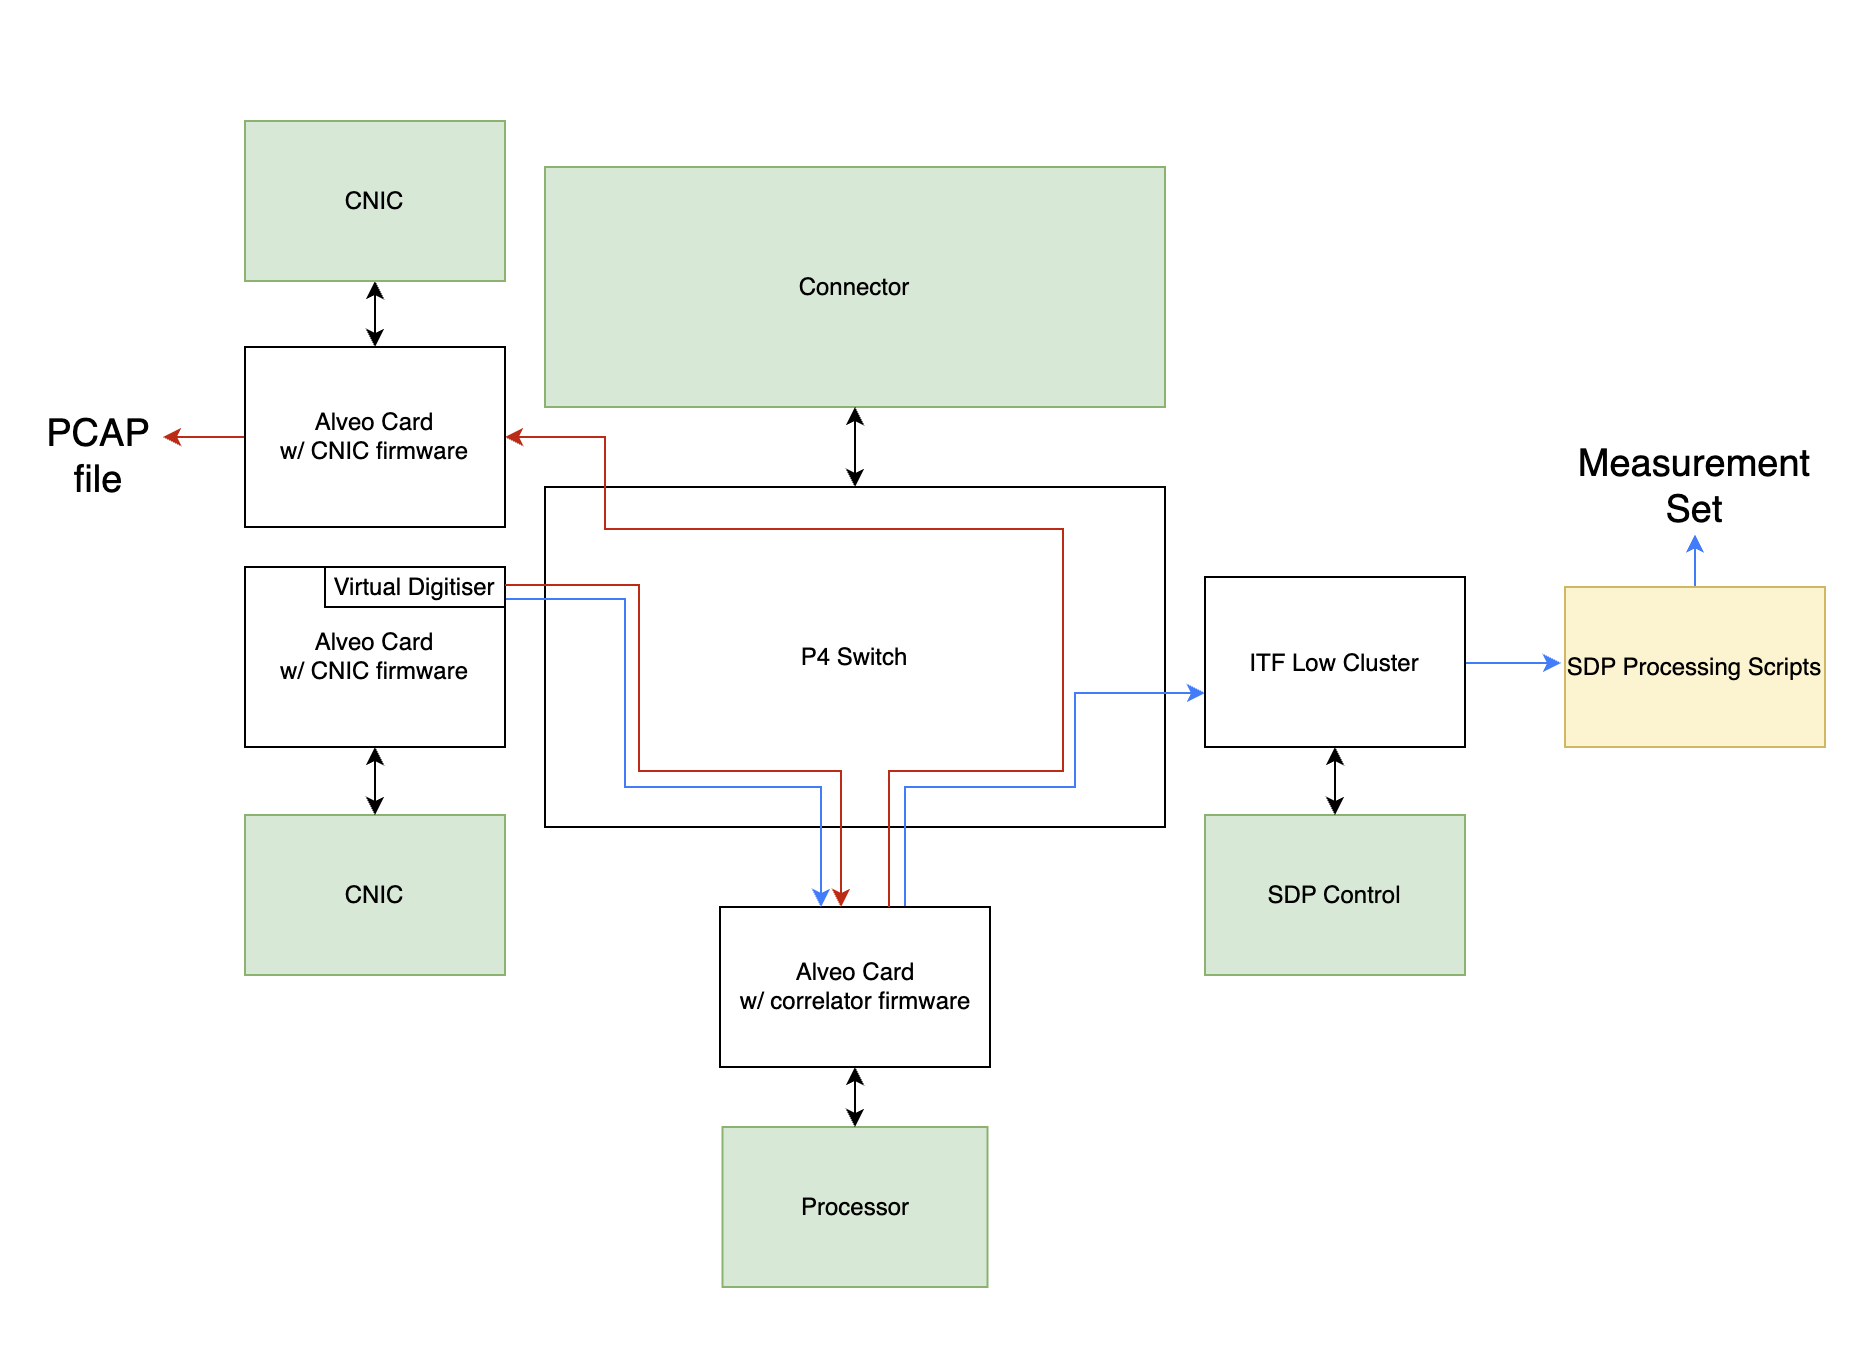
</div>    

## Initial Setup

In [1]:
%switchdb tango-databaseds.sut:10000

Database(tango-databaseds.sut, 10000)

In [2]:
allocator = Device("low-cbf/allocator/0")
cnic = Device("low-cbf/cnic/2")

connector = Device("low-cbf/connector/0")
connector.ConnectToSwitch('{"Switch": "10.10.211.52:50052"}')
print("Connected to Switch")

Connected to Switch


In [3]:
# Helper functions
import time

TIMEOUT = 60.0
INTERVAL = 0.5


def wait_for_state(device, state, timeout=TIMEOUT):
    """
    Wait for device state to have the expected value.

    :param device: device client
    :param state: the expected state
    :param timeout: timeout in seconds
    """

    def predicate():
        return device.state() == state

    description = f"Device state {state.name}"
    logger.info(f"Waiting for device state {state.name}...")
    wait_for_predicate(predicate, description, timeout=timeout)


def wait_for_predicate(predicate, description, timeout=TIMEOUT, interval=INTERVAL):
    """
    Wait for predicate to be true.

    :param predicate: callable to test
    :param description: description to use if test fails
    :param timeout: timeout in seconds
    :param interval: interval between tests of the predicate in seconds

    """
    start = time.time()
    while True:
        if predicate():
            break
        if time.time() >= start + timeout:
            raise TimeoutError(f"{description} not achieved after {timeout} seconds")
        time.sleep(interval)


def wait_for_obs_state(device, obs_state, timeout=TIMEOUT):
    """
    Wait for obsState to have the expected value.

    :param device: device proxy
    :param obs_state: the expected value
    :param timeout: timeout in seconds
    """

    def predicate():
        return device.obsState == obs_state

    description = f"obsState {obs_state.name}"
    logger.info(f"Waiting for device obs_state {obs_state.name}...")
    wait_for_predicate(predicate, description, timeout=timeout)
    logger.info(f"Device obs_state {obs_state.name} has been reached")


def subarray_safe_release(device):
    """
    Safely releases subarray tango device to EMPTY obsState
    """
    if device.obsState == device.obsState.SCANNING:
        logger.info(">> End Scan")
        device.EndScan()
        wait_for_obs_state(device, device.obsState.READY)

    if device.obsState == device.obsState.READY:
        logger.info(">> End")
        device.End()
        wait_for_obs_state(device, device.obsState.IDLE)

    try:
        if device.obsState == device.obsState.IDLE:
            logger.info(">> Releasing All Resources")
            device.ReleaseAllResources()
            wait_for_obs_state(device, device.obsState.EMPTY)
    except DevFailed:
        # Execution block in progress may occur if never configured
        if device.obsState == device.obsState.IDLE:
            logger.info(">> Configure")
            scan_type_ids = list(
                filter(
                    lambda v: v != "interface",
                    json.loads(device.receiveAddresses).keys(),
                )
            )
            device.Configure(
                json.dumps(
                    {
                        "interface": "https://schema.skao.int/ska-sdp-configure/0.4",
                        "scan_type": scan_type_ids[0],
                    }
                )
            )
            wait_for_obs_state(device, device.obsState.READY)
            device.End()
            wait_for_obs_state(device, device.obsState.IDLE)

    if device.obsState == device.obsState.IDLE:
        logger.info(">> Releasing All Resources")
        device.ReleaseAllResources()
        wait_for_obs_state(device, device.obsState.EMPTY)

    if device.obsState == device.obsState.FAULT:
        device.Restart()
        wait_for_obs_state(device, device.obsState.EMPTY)

    assert device.obsState == device.obsState.EMPTY
    logger.info("Tango Device is EMPTY")

In [5]:
import json
import logging
import os
import random
from datetime import date

import ska_sdp_config
import ska_ser_logging
from tango import DevFailed, EventType

# Make sure to connect to the correct SDP namespace
# for running the sdp see https://developer.skao.int/projects/ska-sdp-integration/en/latest/
# KUBE_NAMESPACE = "sut"
# KUBE_PROC_NAMESPACE = f"sdp-deployments"

# # finally set the predetermined host name
# os.environ["SDP_CONFIG_HOST"] = f"ska-sdp-etcd-client.{KUBE_NAMESPACE}"

# # tango device
# # NOTE: use test-sdp/subarray/01 if test-sdp/subarray/02 is not deployed
# sdp_subarray.set_logging_level(5)

# sdp config
# config = ska_sdp_config.Config()

# ska logging
logger = logging.getLogger(__name__)
ska_ser_logging.configure_logging(level=logging.INFO)

In [6]:
nb_stations = 2
station_ids = [x + 1 for x in range(nb_stations)]
channels = [104]
# _, sdp_ip_address = receiveAddresses[scan_type_ids[0]]["vis0"]["host"][0]
# _, sdp_udp_port, _ = receiveAddresses[scan_type_ids[0]]["vis0"]["port"][0]

### CBF Configuration

In [7]:
import json
import os
import sys
from datetime import datetime, timedelta
from time import sleep

import pandas as pd
from IPython.display import Markdown, display, display_markdown

1|2024-02-14T04:53:22.026Z|INFO|MainThread|_init_num_threads|utils.py#145||Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
1|2024-02-14T04:53:22.027Z|INFO|MainThread|_init_num_threads|utils.py#148||Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
1|2024-02-14T04:53:22.027Z|INFO|MainThread|_init_num_threads|utils.py#160||NumExpr defaulting to 8 threads.


In [8]:
def wait_for_attr(  # pylint: disable=too-many-arguments
    device: DeviceProxy,
    attribute: str,
    value=True,
    failure_message: str = "Timed out",
    max_duration: int = 120,
    sleep_per_loop: int = 2,
) -> None:
    """
    Wait until an attribute has a certain value.

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure. Defaults to
        "Timed out". A note about duration is appended.
    :param max_duration: Approximate time-out period (in reality it could be longer due
        to delays waiting for each attribute read)
    :param sleep_per_loop: How long to wait between checks
    :raises RuntimeError: if expected value not seen before timing out
    """
    max_sleeps = max_duration // sleep_per_loop
    for _ in range(max_sleeps + 1):
        if getattr(device, attribute) == value:
            break
        time.sleep(sleep_per_loop)
    else:
        raise RuntimeError(f"{failure_message} after {max_duration}s")

#### Connector routing configuration

Currently ARP replies in the connector are not being received, and thus a work around is made here.

We go into the vis receive pod that is set up during the first part of the notebook to obtain the MAC address through its metadata.

#### Scan JSON

In [9]:
sdp_ip_address = "192.168.1.1"
sdp_udp_port = 10000
sdp_mac_address = "00-00-00-00-00-00"

In [10]:
def get_alveo_port(alveo, allocator):
    hardware_connections = allocator.get_property("hardware_connections")[
        "hardware_connections"
    ]
    for line in hardware_connections:
        # print(line)
        if line.endswith(alveo.serialnumber):
            switch, port, speed, link = line.split()
            _, alveo_port = port.split("=")
            break
    return alveo_port


cnic_port = get_alveo_port(cnic, allocator)
print(cnic_port)

13/0


In [11]:
spead_cfg = {
    "spead": [
        {
            "src": {"frequency": channel, "beam": 1, "sub_array": 1},
            "dst": {"port": cnic_port},
        }
        for channel in channels
    ]
}

connector.ClearSpeadUnicastTable("")

try:
    connector.UpdateSpeadUnicastEntry(json.dumps(spead_cfg))
except Exception as e:
    print(e)
    print("Guillaume should fix this")

print(connector.speadUnicastRoutingTable)

{"Spead": [{"Frequency": "104", "Beam": "1", "Sub_array": "1", "port": "13/0"}]}


In [12]:
connector.ClearSDPIpTable("")
connector.AddSDPIPEntry(
    json.dumps(
        {"sdp_ip": [{"src": {"ip": sdp_ip_address}, "dst": {"port": cnic_port}}]}
    )
)

[array([0], dtype=int32), ['SDP_IP_Routes_Added']]

In [13]:
connector.sdpIpRoutingTable

'{"SDP_IP": [{"IP_Address": "192.168.1.1", "port": "13/0"}]}'

#### Scan

In [14]:
# set up CNIC as duplex
cnic.hbm_pktcontroller__duplex = True

pcap_name = datetime.now().strftime("%Y%m%d_%H%M%S_") + f"eng-model-test.pcap"
rx_filename = os.path.join("/test-data/", pcap_name)
rx_size = 200
n_vis = int(60 / 0.849) + 1
rx_packets = 144 * len(channels) * (n_vis + 1)

print(
    f"Waiting for {rx_packets} packets ({n_vis} visibility packets per stream + start of sequence)"
)
print(f"Setting CNIC Rx filename:\n{rx_filename}")

rx_params = {
    "method": "receive_pcap",
    "arguments": {
        "out_filename": rx_filename,
        "packet_size": rx_size,
        "n_packets": rx_packets,
    },
}
cnic.CallMethod(json.dumps(rx_params))

Waiting for 10368 packets (71 visibility packets per stream + start of sequence)
Setting CNIC Rx filename:
/test-data/20240214_045322_eng-model-test.pcap


'None'

In [15]:
rx_packets

10368

In [16]:
def print_port_status():
    """Show P4 Packet Counters"""
    packet_sent_p1 = 0
    packet_sent_p2 = 0
    packet_received = 0
    ports = json.loads(connector.portStatus)["Ports_Status"]
    print("P4 port status:")
    for port in ports:
        port_name = port["$PORT_NAME"].strip()
        port_enable = port["$PORT_ENABLE"]
        port_up = port["$PORT_UP"]
        port_speed = port["$SPEED"]
        packet_received = port["packets_received"]
        packet_sent = port["packets_sent"]
        print(
            f"Port {port_name:<6}  Enable: {port_enable:<3}   Up: {port_up:<3}   Speed: {port_speed:<6}   Rx: {packet_received:<6}    Tx: {packet_sent:6}"
        )

In [17]:
connector.ResetPortStatistics()

[array([0], dtype=int32), ['Ports Statistics Reset']]

In [27]:
print(cnic_port)
print_port_status()

13/0
P4 port status:
Port 1/0     Enable: 1     Up: 1     Speed: 10G      Rx: 592       Tx:    348
Port 2/0     Enable: 1     Up: 1     Speed: 100G     Rx: 4791903    Tx:      0
Port 7/0     Enable: 1     Up: 1     Speed: 100G     Rx: 113       Tx:    584
Port 9/0     Enable: 1     Up: 0     Speed: 100G     Rx: 0         Tx:      0
Port 11/0    Enable: 1     Up: 0     Speed: 100G     Rx: 0         Tx:      0
Port 13/0    Enable: 1     Up: 1     Speed: 100G     Rx: 0         Tx:  12644
Port 15/0    Enable: 1     Up: 1     Speed: 100G     Rx: 118       Tx:    584
Port 17/0    Enable: 1     Up: 1     Speed: 100G     Rx: 117       Tx:    992
Port 31/0    Enable: 1     Up: 0     Speed: 10G      Rx: 0         Tx:      0
Port 32/0    Enable: 1     Up: 1     Speed: 100G     Rx: 8         Tx:      0


### End Scan